## **Losses in PyTorch**

Let's start by seeing how we calculate the loss with PyTorch. Through the nn module, PyTorch provides losses such as the cross-entropy loss (nn.CrossEntropyLoss). You'll usually see the loss assigned to criterion. As noted in the last part, with a classification problem such as MNIST, we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

Something really important to note here. Looking at the documentation for nn.CrossEntropyLoss,



> This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the logits or scores. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one. It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.



In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2890, grad_fn=<NllLossBackward>)



In my experience it's more convenient to build the model with a log-softmax output using nn.LogSoftmax or F.log_softmax. Then you can get the actual probabilities by taking the exponential torch.exp(output). With a log-softmax output, you want to use the negative log likelihood loss, nn.NLLLoss

> **Exercise:** Build a model that returns the log-softmax as the output and calculate the loss using the negative log likelihood loss. Note that for nn.LogSoftmax and F.log_softmax you'll need to set the dim keyword argument appropriately. dim=0 calculates softmax across the rows, so each column sums to 1, while dim=1 calculates across the columns so each row sums to 1. Think about what you want the output to be and choose dim appropriately..

In [2]:
# TODO: Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# TODO: Define the loss
criterion = nn.NLLLoss()

### Run this to check your work
# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2919, grad_fn=<NllLossBackward>)


In [3]:
print('Before backward pass: \n',model[0].weight.grad)

loss.backward()

print('After backward pass: \n',model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0031, -0.0031, -0.0031,  ..., -0.0031, -0.0031, -0.0031],
        [ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        [-0.0011, -0.0011, -0.0011,  ..., -0.0011, -0.0011, -0.0011],
        ...,
        [-0.0014, -0.0014, -0.0014,  ..., -0.0014, -0.0014, -0.0014],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005]])



##**Autograd**
Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, autograd, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set requires_grad = True on a tensor. You can do this at creation with the requires_grad keyword, or at any time with x.requires_grad_(True).

You can turn off gradients for a block of code with the torch.no_grad() content:

>```
 x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with torch.set_grad_enabled(True|False).

The gradients are computed with respect to some variable z with z.backward(). This does a backward pass through the operations that created z.



In [4]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[-0.4541, -0.9418],
        [-0.3777, -0.5073]], requires_grad=True)


In [5]:
y = x**2
print(y)

tensor([[0.2062, 0.8869],
        [0.1427, 0.2574]], grad_fn=<PowBackward0>)


Below we can see the operation that created y, a power operation PowBackward0.

In [6]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor y to a scalar value, the mean.

In [7]:
z = y.mean()
print(z)

tensor(0.3733, grad_fn=<MeanBackward0>)


You can check the gradients for x and y but they are empty currently.

In [8]:
print(x.grad)

None


To calculate the gradients, you need to run the .backward method on a Variable, z for example. This will calculate the gradient for z with respect to x

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [9]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.2270, -0.4709],
        [-0.1889, -0.2537]])
tensor([[-0.2270, -0.4709],
        [-0.1889, -0.2537]], grad_fn=<DivBackward0>)


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the cost with respect to the weights. With PyTorch, we run data forward through the network to calculate the loss, then, go backwards to calculate the gradients with respect to the loss. Once we have the gradients we can make a gradient descent step.

## **Loss and Autograd together**
When we create a network with PyTorch, all of the parameters are initialized with requires_grad = True. This means that when we calculate the loss and call loss.backward(), the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [10]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0008, -0.0008, -0.0008,  ..., -0.0008, -0.0008, -0.0008],
        [ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        [-0.0017, -0.0017, -0.0017,  ..., -0.0017, -0.0017, -0.0017],
        ...,
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003],
        [ 0.0028,  0.0028,  0.0028,  ...,  0.0028,  0.0028,  0.0028],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


## **Training the network!**
There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's optim package. For example we can use stochastic gradient descent with optim.SGD. You can see how to define an optimizer below.

In [11]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)
model.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)>

Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network
* Use the network output to calculate the loss
* Perform a backward pass through the network with loss.backward() to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes. Note that I have a line of code optimizer.zero_grad(). When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [12]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 0.0204, -0.0119, -0.0020,  ..., -0.0317, -0.0020,  0.0257],
        [ 0.0040, -0.0127,  0.0270,  ...,  0.0341, -0.0066, -0.0034],
        [-0.0275, -0.0160, -0.0328,  ...,  0.0264, -0.0319,  0.0211],
        ...,
        [-0.0329,  0.0110, -0.0309,  ..., -0.0051,  0.0323,  0.0206],
        [-0.0185, -0.0242, -0.0176,  ...,  0.0167,  0.0080, -0.0105],
        [ 0.0285, -0.0058, -0.0025,  ..., -0.0136, -0.0153,  0.0308]],
       requires_grad=True)
Gradient - tensor([[-0.0016, -0.0016, -0.0016,  ..., -0.0016, -0.0016, -0.0016],
        [ 0.0011,  0.0011,  0.0011,  ...,  0.0011,  0.0011,  0.0011],
        [ 0.0019,  0.0019,  0.0019,  ...,  0.0019,  0.0019,  0.0019],
        ...,
        [ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        [ 0.0010,  0.0010,  0.0010,  ...,  0.0010,  0.0010,  0.0010],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005]])


In [13]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0204, -0.0118, -0.0020,  ..., -0.0317, -0.0020,  0.0257],
        [ 0.0040, -0.0127,  0.0270,  ...,  0.0341, -0.0066, -0.0034],
        [-0.0276, -0.0160, -0.0328,  ...,  0.0264, -0.0319,  0.0210],
        ...,
        [-0.0329,  0.0110, -0.0309,  ..., -0.0051,  0.0323,  0.0206],
        [-0.0185, -0.0242, -0.0176,  ...,  0.0166,  0.0079, -0.0105],
        [ 0.0285, -0.0058, -0.0025,  ..., -0.0136, -0.0153,  0.0308]],
       requires_grad=True)


## **Training for real**
Now we'll put this algorithm into a loop so we can go through all the images. Some nomenclature, one pass through the entire dataset is called an epoch. So here we're going to loop through trainloader to get our training batches. For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

> **Exercise:** Implement the training pass for our network. If you implemented it correctly, you should see the training loss drop with each epoch.

In [14]:
## Your solution here

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()

        # TODO: Training pass
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.8102904685270558
Training loss: 0.7978063867226847
Training loss: 0.5170010748797896
Training loss: 0.4292265923419741
Training loss: 0.38770882437414705



With the network trained, we can check out it's predictions.

--2020-01-13 00:38:49--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



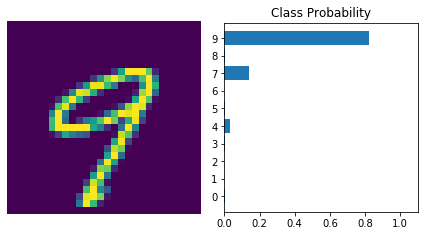

In [20]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py ## To solve problem with helper
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

Now our network is brilliant. It can accurately predict the digits in our images. Next up you'll write the code for training a neural network on a more complex dataset.